In [1]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import transformers

from sklearn.metrics import precision_score,recall_score,f1_score

import sys
sys.path.append("..")

import os
import uuid

/home/newdisk/jxh/anaconda/envs/sft2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
transformer_name = '../models/finbert'

tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)
## usage：
# tokenizer("hello world!")
# tokenizer.tokenize("hello world!")
# tokenizer.encode("hello world!")
# tokenizer.convert_ids_to_tokens(tokenizer.encode("hello world"))

In [4]:
dataset = datasets.load_dataset("../data/finan_news_senti_data", split=["train", "test"])
dataset[0][0]

Repo card metadata block was not found. Setting CardData to empty.


{'Unnamed: 0': 0,
 '日期': '2019年2月14日',
 '公司': '盛运环保',
 '代码': 300090,
 '正负面': 0,
 '标题': '盛运环保：37.48亿元到期债务未清偿',
 '正文': '盛运环保2月13日晚间发布公告称，截至目前，共有37.48亿元到期债务未清偿。'}

In [5]:
# 筛选
# dataset = [part_data.filter(lambda example: example["task"]=="FINFE" and ("积极" in example["output"] or "消极" in example["output"]) for part_data in dataset]

# input生成
def tokenize_and_numericalize_example(example, tokenizer):
    ids = tokenizer(example["正文"], truncation=True)["input_ids"]
    return {"ids": ids, "label": example['正负面']}

train_data = dataset[0].map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)
test_data = dataset[1].map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)

In [6]:
pad_index = tokenizer.pad_token_id

In [7]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [8]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [9]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [10]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [11]:
batch_size = 8

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [12]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids, attention_mask=None):
        # ids = [batch size, seq len]
        output = self.transformer(ids, output_attentions=False, attention_mask = attention_mask)
        hidden = output.last_hidden_state
        # hidden = [batch size, seq len, hidden dim]
        # attention = output.attentions[-1]
        # attention = [batch size, n heads, seq len, seq len]
        cls_hidden = hidden[:, 0, :]
        prediction = self.fc(torch.tanh(cls_hidden))
        # prediction = [batch size, output dim]
        return prediction

In [13]:
output_dim = 2
freeze = True
transformer = transformers.AutoModel.from_pretrained(transformer_name)
model = Transformer(transformer, output_dim, freeze)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 1,538 trainable parameters


In [15]:
def train(data_loader, model, criterion, optimizer, device,scheduler=None):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        attention_mask = (ids != pad_index).float().to(device)  # 生成attention_mask
        # print(ids.shape,attention_mask.shape)
        prediction = model(ids,attention_mask=attention_mask)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler!=None:
            scheduler.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [16]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            attention_mask = (ids != pad_index).float().to(device)  # 生成attention_mask
            prediction = model(ids,attention_mask=attention_mask)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(torch.argmax(prediction, dim=1).cpu().numpy())
    
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    return np.mean(epoch_losses), np.mean(epoch_accs), f1

In [17]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [18]:
def save_checkpoints(model,path,file_name,uid):
    torch.save(model.state_dict(), os.path.join(path,uid+"_"+file_name))

In [19]:
# 超参数
metrics = collections.defaultdict(list)     
lr = 2e-5
optimizer = optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()   # nn.CrossEntropyLoss()  nn.MSELoss()      
n_epochs = 50
def rule(epoch):
    return epoch / 5 if epoch<=5 else 0.96 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=rule) # 选定调整方法
best_valid_loss = float("inf") 
uid = str(uuid.uuid4())

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device, scheduler=None
    )
    valid_loss, valid_acc, f1 = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    metrics["f1_score"].append(f1)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        save_checkpoints(model,"../outputs","bert_sentiment.pt",uid)
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")
    print(f"valid_f1: {f1:.3f}")

evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.13it/s]


epoch: 0
train_loss: 0.654, train_acc: 0.633
valid_loss: 0.593, valid_acc: 0.765
valid_f1: 0.765


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.11it/s]


epoch: 1
train_loss: 0.576, train_acc: 0.763
valid_loss: 0.531, valid_acc: 0.802
valid_f1: 0.802


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.11it/s]


epoch: 2
train_loss: 0.532, train_acc: 0.784
valid_loss: 0.492, valid_acc: 0.817
valid_f1: 0.817


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.11it/s]


epoch: 3
train_loss: 0.499, train_acc: 0.800
valid_loss: 0.465, valid_acc: 0.823
valid_f1: 0.824


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.08it/s]


epoch: 4
train_loss: 0.478, train_acc: 0.808
valid_loss: 0.444, valid_acc: 0.834
valid_f1: 0.835


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.09it/s]


epoch: 5
train_loss: 0.462, train_acc: 0.813
valid_loss: 0.430, valid_acc: 0.839
valid_f1: 0.840


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.12it/s]


epoch: 6
train_loss: 0.445, train_acc: 0.818
valid_loss: 0.417, valid_acc: 0.845
valid_f1: 0.846


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.09it/s]


epoch: 7
train_loss: 0.436, train_acc: 0.818
valid_loss: 0.407, valid_acc: 0.850
valid_f1: 0.850


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.09it/s]


epoch: 8
train_loss: 0.429, train_acc: 0.828
valid_loss: 0.399, valid_acc: 0.851
valid_f1: 0.852


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 9
train_loss: 0.424, train_acc: 0.823
valid_loss: 0.392, valid_acc: 0.854
valid_f1: 0.855


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.13it/s]


epoch: 10
train_loss: 0.411, train_acc: 0.835
valid_loss: 0.386, valid_acc: 0.855
valid_f1: 0.856


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 11
train_loss: 0.407, train_acc: 0.834
valid_loss: 0.381, valid_acc: 0.858
valid_f1: 0.858


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.11it/s]


epoch: 12
train_loss: 0.406, train_acc: 0.832
valid_loss: 0.377, valid_acc: 0.859
valid_f1: 0.860


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 13
train_loss: 0.400, train_acc: 0.838
valid_loss: 0.374, valid_acc: 0.861
valid_f1: 0.861


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.13it/s]


epoch: 14
train_loss: 0.396, train_acc: 0.838
valid_loss: 0.369, valid_acc: 0.863
valid_f1: 0.863


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.09it/s]


epoch: 15
train_loss: 0.393, train_acc: 0.835
valid_loss: 0.365, valid_acc: 0.865
valid_f1: 0.865


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.09it/s]


epoch: 16
train_loss: 0.390, train_acc: 0.839
valid_loss: 0.363, valid_acc: 0.864
valid_f1: 0.865


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.09it/s]


epoch: 17
train_loss: 0.387, train_acc: 0.842
valid_loss: 0.359, valid_acc: 0.866
valid_f1: 0.867


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.11it/s]


epoch: 18
train_loss: 0.380, train_acc: 0.844
valid_loss: 0.357, valid_acc: 0.866
valid_f1: 0.867


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.12it/s]


epoch: 19
train_loss: 0.378, train_acc: 0.844
valid_loss: 0.355, valid_acc: 0.867
valid_f1: 0.867


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.12it/s]


epoch: 20
train_loss: 0.379, train_acc: 0.846
valid_loss: 0.352, valid_acc: 0.869
valid_f1: 0.870


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.12it/s]


epoch: 21
train_loss: 0.380, train_acc: 0.845
valid_loss: 0.350, valid_acc: 0.867
valid_f1: 0.868


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.11it/s]


epoch: 22
train_loss: 0.377, train_acc: 0.842
valid_loss: 0.347, valid_acc: 0.869
valid_f1: 0.870


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.11it/s]


epoch: 23
train_loss: 0.373, train_acc: 0.847
valid_loss: 0.346, valid_acc: 0.871
valid_f1: 0.871


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.09it/s]


epoch: 24
train_loss: 0.373, train_acc: 0.847
valid_loss: 0.344, valid_acc: 0.869
valid_f1: 0.870


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 25
train_loss: 0.369, train_acc: 0.851
valid_loss: 0.342, valid_acc: 0.869
valid_f1: 0.870


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.07it/s]


epoch: 26
train_loss: 0.369, train_acc: 0.849
valid_loss: 0.340, valid_acc: 0.873
valid_f1: 0.874


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 27
train_loss: 0.366, train_acc: 0.853
valid_loss: 0.339, valid_acc: 0.872
valid_f1: 0.872


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.07it/s]


epoch: 28
train_loss: 0.364, train_acc: 0.848
valid_loss: 0.337, valid_acc: 0.872
valid_f1: 0.872


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 29
train_loss: 0.369, train_acc: 0.848
valid_loss: 0.336, valid_acc: 0.872
valid_f1: 0.873


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.09it/s]


epoch: 30
train_loss: 0.364, train_acc: 0.854
valid_loss: 0.335, valid_acc: 0.876
valid_f1: 0.875


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 31
train_loss: 0.361, train_acc: 0.849
valid_loss: 0.334, valid_acc: 0.875
valid_f1: 0.876


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.11it/s]


epoch: 32
train_loss: 0.359, train_acc: 0.851
valid_loss: 0.332, valid_acc: 0.875
valid_f1: 0.874


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 33
train_loss: 0.363, train_acc: 0.848
valid_loss: 0.331, valid_acc: 0.874
valid_f1: 0.875


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.07it/s]


epoch: 34
train_loss: 0.358, train_acc: 0.854
valid_loss: 0.330, valid_acc: 0.877
valid_f1: 0.877


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.09it/s]


epoch: 35
train_loss: 0.358, train_acc: 0.854
valid_loss: 0.329, valid_acc: 0.877
valid_f1: 0.877


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 36
train_loss: 0.356, train_acc: 0.854
valid_loss: 0.329, valid_acc: 0.878
valid_f1: 0.878


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.22it/s]


epoch: 37
train_loss: 0.355, train_acc: 0.855
valid_loss: 0.327, valid_acc: 0.879
valid_f1: 0.879


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.09it/s]


epoch: 38
train_loss: 0.350, train_acc: 0.858
valid_loss: 0.326, valid_acc: 0.878
valid_f1: 0.878


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 39
train_loss: 0.356, train_acc: 0.854
valid_loss: 0.325, valid_acc: 0.880
valid_f1: 0.880


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 40
train_loss: 0.352, train_acc: 0.855
valid_loss: 0.324, valid_acc: 0.881
valid_f1: 0.880


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.11it/s]


epoch: 41
train_loss: 0.354, train_acc: 0.855
valid_loss: 0.323, valid_acc: 0.881
valid_f1: 0.880


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.13it/s]


epoch: 42
train_loss: 0.354, train_acc: 0.851
valid_loss: 0.323, valid_acc: 0.880
valid_f1: 0.880


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.13it/s]


epoch: 43
train_loss: 0.351, train_acc: 0.854
valid_loss: 0.322, valid_acc: 0.881
valid_f1: 0.881


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.13it/s]


epoch: 44
train_loss: 0.347, train_acc: 0.858
valid_loss: 0.321, valid_acc: 0.881
valid_f1: 0.881


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.12it/s]


epoch: 45
train_loss: 0.349, train_acc: 0.860
valid_loss: 0.320, valid_acc: 0.882
valid_f1: 0.881


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.11it/s]


epoch: 46
train_loss: 0.346, train_acc: 0.856
valid_loss: 0.320, valid_acc: 0.882
valid_f1: 0.882


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.11it/s]


epoch: 47
train_loss: 0.345, train_acc: 0.856
valid_loss: 0.319, valid_acc: 0.882
valid_f1: 0.881


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.12it/s]


epoch: 48
train_loss: 0.352, train_acc: 0.854
valid_loss: 0.318, valid_acc: 0.881
valid_f1: 0.881


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.24it/s]


epoch: 49
train_loss: 0.347, train_acc: 0.856
valid_loss: 0.318, valid_acc: 0.884
valid_f1: 0.884


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.14it/s]


epoch: 50
train_loss: 0.346, train_acc: 0.860
valid_loss: 0.317, valid_acc: 0.882
valid_f1: 0.882


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.29it/s]


epoch: 51
train_loss: 0.347, train_acc: 0.859
valid_loss: 0.317, valid_acc: 0.882
valid_f1: 0.882


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.09it/s]


epoch: 52
train_loss: 0.344, train_acc: 0.857
valid_loss: 0.316, valid_acc: 0.883
valid_f1: 0.883


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 53
train_loss: 0.344, train_acc: 0.857
valid_loss: 0.315, valid_acc: 0.883
valid_f1: 0.883


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.11it/s]


epoch: 54
train_loss: 0.344, train_acc: 0.859
valid_loss: 0.315, valid_acc: 0.883
valid_f1: 0.883


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.11it/s]


epoch: 55
train_loss: 0.337, train_acc: 0.864
valid_loss: 0.314, valid_acc: 0.884
valid_f1: 0.884


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.14it/s]


epoch: 56
train_loss: 0.339, train_acc: 0.863
valid_loss: 0.314, valid_acc: 0.883
valid_f1: 0.883


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.13it/s]


epoch: 57
train_loss: 0.340, train_acc: 0.859
valid_loss: 0.314, valid_acc: 0.883
valid_f1: 0.882


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 58
train_loss: 0.343, train_acc: 0.857
valid_loss: 0.313, valid_acc: 0.884
valid_f1: 0.883


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 59
train_loss: 0.341, train_acc: 0.858
valid_loss: 0.312, valid_acc: 0.885
valid_f1: 0.885


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 60
train_loss: 0.341, train_acc: 0.859
valid_loss: 0.311, valid_acc: 0.885
valid_f1: 0.885


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.14it/s]


epoch: 61
train_loss: 0.343, train_acc: 0.858
valid_loss: 0.311, valid_acc: 0.887
valid_f1: 0.886


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.12it/s]


epoch: 62
train_loss: 0.341, train_acc: 0.859
valid_loss: 0.310, valid_acc: 0.885
valid_f1: 0.885


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.16it/s]


epoch: 63
train_loss: 0.341, train_acc: 0.860
valid_loss: 0.311, valid_acc: 0.883
valid_f1: 0.883


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.13it/s]


epoch: 64
train_loss: 0.340, train_acc: 0.858
valid_loss: 0.310, valid_acc: 0.885
valid_f1: 0.885


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.12it/s]


epoch: 65
train_loss: 0.340, train_acc: 0.862
valid_loss: 0.309, valid_acc: 0.885
valid_f1: 0.885


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.11it/s]


epoch: 66
train_loss: 0.341, train_acc: 0.863
valid_loss: 0.309, valid_acc: 0.886
valid_f1: 0.886


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 67
train_loss: 0.335, train_acc: 0.862
valid_loss: 0.308, valid_acc: 0.885
valid_f1: 0.885


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.11it/s]


epoch: 68
train_loss: 0.338, train_acc: 0.860
valid_loss: 0.308, valid_acc: 0.886
valid_f1: 0.886


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.12it/s]


epoch: 69
train_loss: 0.337, train_acc: 0.859
valid_loss: 0.308, valid_acc: 0.885
valid_f1: 0.885


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.09it/s]


epoch: 70
train_loss: 0.339, train_acc: 0.861
valid_loss: 0.308, valid_acc: 0.885
valid_f1: 0.885


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.12it/s]


epoch: 71
train_loss: 0.335, train_acc: 0.862
valid_loss: 0.307, valid_acc: 0.885
valid_f1: 0.885


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.13it/s]


epoch: 72
train_loss: 0.339, train_acc: 0.862
valid_loss: 0.307, valid_acc: 0.889
valid_f1: 0.889


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.14it/s]


epoch: 73
train_loss: 0.333, train_acc: 0.864
valid_loss: 0.307, valid_acc: 0.884
valid_f1: 0.883


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.11it/s]


epoch: 74
train_loss: 0.331, train_acc: 0.865
valid_loss: 0.306, valid_acc: 0.887
valid_f1: 0.887


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 75
train_loss: 0.336, train_acc: 0.864
valid_loss: 0.305, valid_acc: 0.886
valid_f1: 0.885


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.05it/s]


epoch: 76
train_loss: 0.328, train_acc: 0.866
valid_loss: 0.305, valid_acc: 0.889
valid_f1: 0.888


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.14it/s]


epoch: 77
train_loss: 0.335, train_acc: 0.859
valid_loss: 0.304, valid_acc: 0.888
valid_f1: 0.888


training...:  21%|██        | 268/1288 [00:09<00:37, 26.99it/s]


KeyboardInterrupt: 

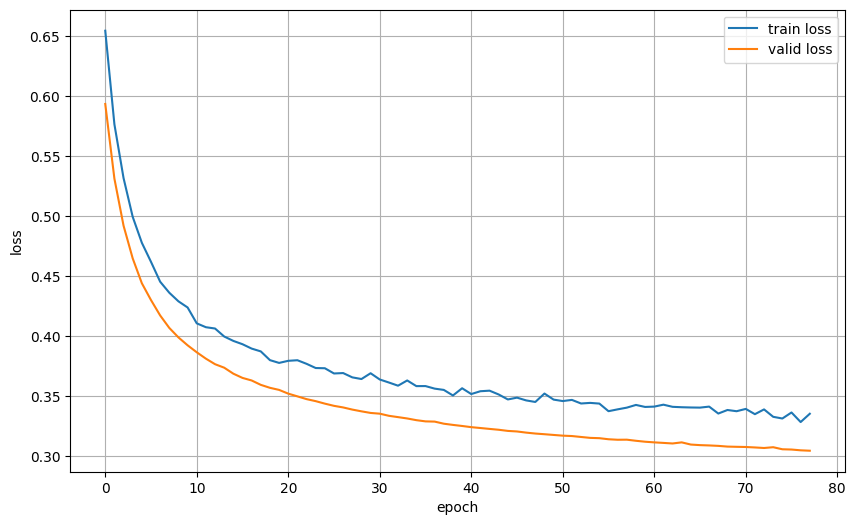

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
# ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

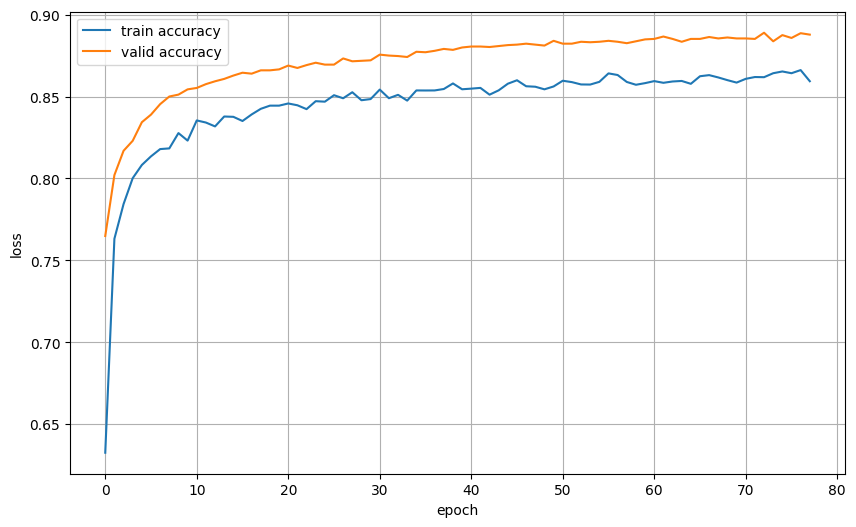

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
# ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [ ]:
# model.load_state_dict(torch.load("transformer.pt"))

test_loss, test_acc, test_f1 = evaluate(test_data_loader, model, criterion, device)
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}, test_f1: {test_f1:.3f}")

evaluating...: 100%|██████████| 300/300 [00:11<00:00, 26.65it/s]

test_loss: 0.279, test_acc: 0.900, test_f1: 0.900


In [ ]:
def predict_sentiment(text, model, tokenizer, device):
    ids= tokenizer(text)["input_ids"]
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [ ]:
text = "迪威迅股权质押违约 控股股东或被动减持"
# text = "银行股全线飘绿 平安银行跌4%"

predict_sentiment(text, model, tokenizer, device)

(0, 0.8938189744949341)

In [ ]:
text = "平安银行理财子公司获批筹建：注册资本50亿 股份行第五家"

predict_sentiment(text, model, tokenizer, device)

(1, 0.9783540368080139)